# Week 5

## Part 1: Exploratory data visualzation, two variables  

*Exercise:* Questions from DAOST Chapter 3. 

> * Looking at Fig 3-1, Janert writes "the data itself shows clearly that the amount of random noise in the data is small". What do you think his argument is?
> * Can you think of a real-world example of a multivariate relationship like the one in Fig 3-3 (lower right panel)?
> * What are the two methods Janert metions for smoothing noisy data? Can you think of other ones?
> * What are residuals? Why is it a good idea to plot the residuals of your fit?
> * Explain in your own words the point of the smooth tube in figure 3-7.
> * What the h#ll is banking and what part of our visual system does it use to help us see patterns? What are potential problems with banking?
> * Summarize the discussion of Graphical Analysis and Presentation Graphics on pp. 68-69 in your own words.


*Exercise 2.2*: Logarithms and logarithmic plots. 

>    * What kind of relationships will a semi-log plot help you discover? 
>    * What kind of functions will loglog plots help you see?



> * Second, create a version of this plot from Week 1, where you display the $y$-axis on log-scale. Comment on what the plot looks like. Do any new insights arise?

The plot 



In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Loading the data 
data_path = os.path.abspath(os.path.join(os.pardir, "data"))
cleaned_data_path = os.path.join(data_path, "Police_Department_Incident_Reports_Complete.csv")
df = pd.read_csv(cleaned_data_path)

# Define focus crimes
focuscrimes = set(['WEAPON LAWS', 'PROSTITUTION', 'ROBBERY', 'BURGLARY', 'ASSAULT', 
                   'DRUG/NARCOTIC', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY'])

# Filter data for focus crimes
df_focus = df[df['Category'].isin(focuscrimes)]

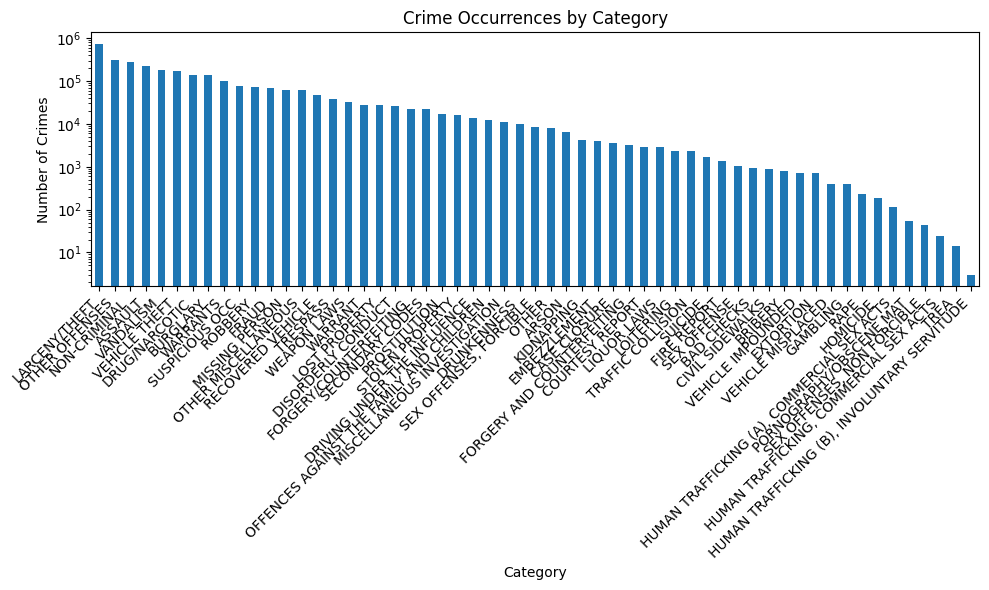

In [4]:
plt.figure(figsize=(10, 6))
category_counts = df['Category'].value_counts()
category_counts.plot(kind='bar')

# Set y-axis to log scale
plt.yscale('log')

# Add title and labels
plt.title('Crime Occurrences by Category')
plt.xlabel('Category')
plt.ylabel('Number of Crimes')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

> * Third, let's also try a loglog plot. Inspired by this article I would expect that especially theft could be characterized by a power law distribution also in San Francisco. Let's see if I'm right. 
>   - *Step 1:* Divide San Francisco into a grid **roughly** $100m \times 100m$. 
>   - *Step 2:* Count the number of thefts occurring within each grid-square (use all data for all time).
>   - *Step 3:* Tally the counts. Count the number of squares with $k=0$ thefts. We call this $N(0)$. Next, count the number of grids with one crime to get $N(k=1)$. Keep going like this all the way up to $k=C_{max}$, where $C_{max}$ is the highest count of crimes you find in any grid space. 
>   - *Step 4:* Plot the distribution of $k+1$ vs $N(k)$ on linear axes.
>   - *Step 5:* Plot the distribution of $k+1$ vs $N(k)$ on loglog axes.
>   - *Step 6:* Answer the question. Was Sune correct in assuming that there is a power-law distribution of theft?


In [ ]:
import numpy as np

# Filter data for thefts only
df_theft = df[df['Category'] == 'LARCENY/THEFT'].copy()

print('Minimum latitude:', df_theft['Latitude (Y)'].min())
print('Maximum latitude:', df_theft['Latitude (Y)'].max())
print('Minimum longitude:', df_theft['Longitude (X)'].min())
print('Maximum longitude:', df_theft['Longitude (X)'].max())

# Step 1: Bounding box for SF - based on the above values and excluding outliers
min_lon, max_lon = -122.53, -122.35
min_lat, max_lat = 37.70, 37.82

# Keep only points within the bounding box
df_theft = df_theft[
    (df_theft['Longitude (X)'] >= min_lon) & (df_theft['Longitude (X)'] <= max_lon) &
    (df_theft['Latitude (Y)'] >= min_lat)   & (df_theft['Latitude (Y)'] <= max_lat)
]

# Approximate conversion from meters to degrees of latitude
cell_size_lat = 100 / 111_320  # 100 m in degrees of latitude

# For longitude
mean_lat = df_theft['Latitude (Y)'].mean() if not df_theft.empty else 37.76
cell_size_lon = 100 / (111_320 * np.cos(np.deg2rad(mean_lat)))

Minimum latitude: 37.70784759521485
Maximum latitude: 90.0
Minimum longitude: -122.51364206429
Maximum longitude: -120.5


In [ ]:
# Create arrays of bin edges along longitude (x) and latitude (y)
lon_edges = np.arange(min_lon, max_lon + cell_size_lon, cell_size_lon)
lat_edges = np.arange(min_lat, max_lat + cell_size_lat, cell_size_lat)

# In case the bounding box or data is empty, guard against zero-size arrays
if len(lon_edges) < 2 or len(lat_edges) < 2:
    raise ValueError("Not enough data or bins to create a 2D histogram. "
                     "Check your bounding box or theft data.")

# Extract the longitude and latitude arrays
x = df_theft['Longitude (X)'].values
y = df_theft['Latitude (Y)'].values

# Create a 2D histogram:
#   H[i, j] = number of thefts in the bin [lon_edges[i], lon_edges[i+1]),
#                                        [lat_edges[j], lat_edges[j+1])
H, xedges, yedges = np.histogram2d(x, y, bins=[lon_edges, lat_edges])

# Step 2: Convert histogram to integer counts
H = H.astype(int)

# Flatten the 2D histogram into 1D
H_flat = H.flatten()

# Tally the number of grid cells for each theft count k
# distribution.index = k, distribution.values = N(k)
# Step 3
distribution = pd.value_counts(H_flat).sort_index()

/var/folders/4x/yhtdnw892qb8jnq411phhh340000gn/T/ipykernel_9417/1122119695.py:27: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  distribution = pd.value_counts(H_flat).sort_index()


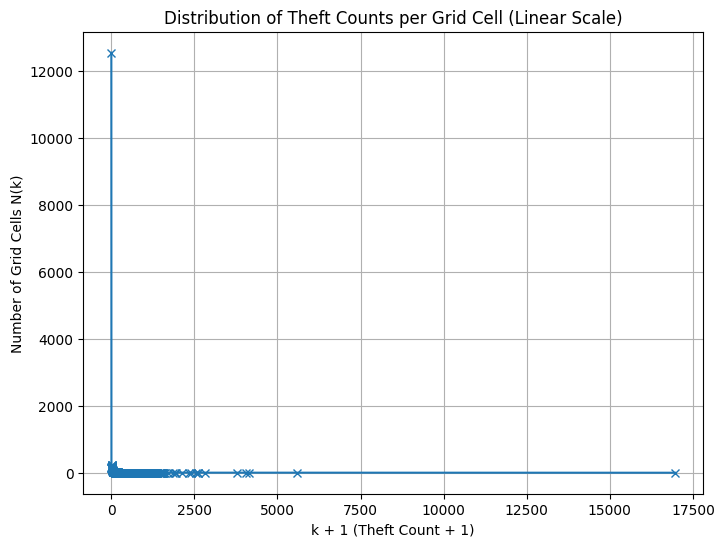

In [11]:
# Step 4
plt.figure(figsize=(8, 6))
plt.plot(distribution.index + 1, distribution.values, marker='x', linestyle='-')
plt.title('Distribution of Theft Counts per Grid Cell (Linear Scale)')
plt.xlabel('k + 1 (Theft Count + 1)')
plt.ylabel('Number of Grid Cells N(k)')
plt.grid(True)
plt.show()

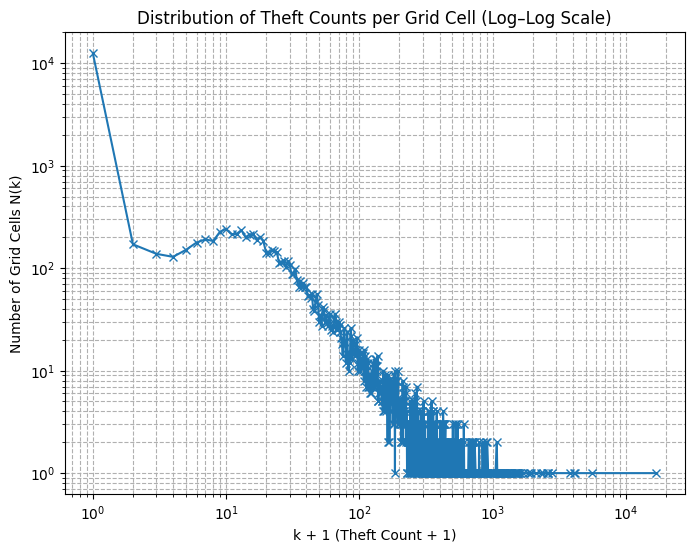

In [10]:
# Step 5
plt.figure(figsize=(8, 6))
plt.loglog(distribution.index + 1, distribution.values, marker='x', linestyle='-')
plt.title('Distribution of Theft Counts per Grid Cell (Log–Log Scale)')
plt.xlabel('k + 1 (Theft Count + 1)')
plt.ylabel('Number of Grid Cells N(k)')
plt.grid(True, which="both", linestyle="--")
plt.show()


> Was Sune correct in assuming that there is a power-law distribution of theft?

There is not a perfect power-law distribution, as the data points in the log-log plot do not follow a straight line. However, it is partially following a power-law, especially at the heavy tail. 


## Part 2: Linear Regression

*Exercise*: Create the 91 scatterplots.
> * Display the plots in a $5$ by $9$ subplot matrix.
> * Just inspecting this matrix, which crime-types look correlated and which one look like they're very different?

In [14]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Group by Category and Day of Week
grouped = df_focus.groupby(['Category', 'Day of Week']).size().reset_index(name='count')

# Pivot so that each row is a Category, and each column is a Day of Week
pivot_df = grouped.pivot(index='Category', columns='Day of Week', values='count').fillna(0)

# Reorder columns to ensure Mon-Sun ordering
pivot_df = pivot_df[day_order]

pivot_df

Day of Week      Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  \
Category                                                                  
ASSAULT           30247    29846      30242     29801   32549     34701   
BURGLARY          19929    20034      20789     20527   23298     18666   
DRUG/NARCOTIC     19430    22902      25243     22315   19395     16470   
LARCENY/THEFT    100330    99920     103902    103176  115632    113241   
PROSTITUTION       1205     3122       3415      3826    2945      1728   
ROBBERY           10527    10340      10394     10305   10680     11206   
STOLEN PROPERTY    2257     2343       2495      2286    2251      2109   
VANDALISM         23942    23511      24152     23718   27799     27951   
VEHICLE THEFT     24258    24130      24856     24593   27940     26037   
WEAPON LAWS        4498     4579       4836      4722    4844      4614   

Day of Week      Sunday  
Category                 
ASSAULT           34021  
BURGLARY          17503  
DRUG/NARCOTIC     15472  
LARCENY/THEFT    102304  
PROSTITUTION       1150  
ROBBERY           10827  
STOLEN PROPERTY    2000  
VANDALISM         25810  
VEHICLE THEFT     24204  
WEAPON LAWS        4242

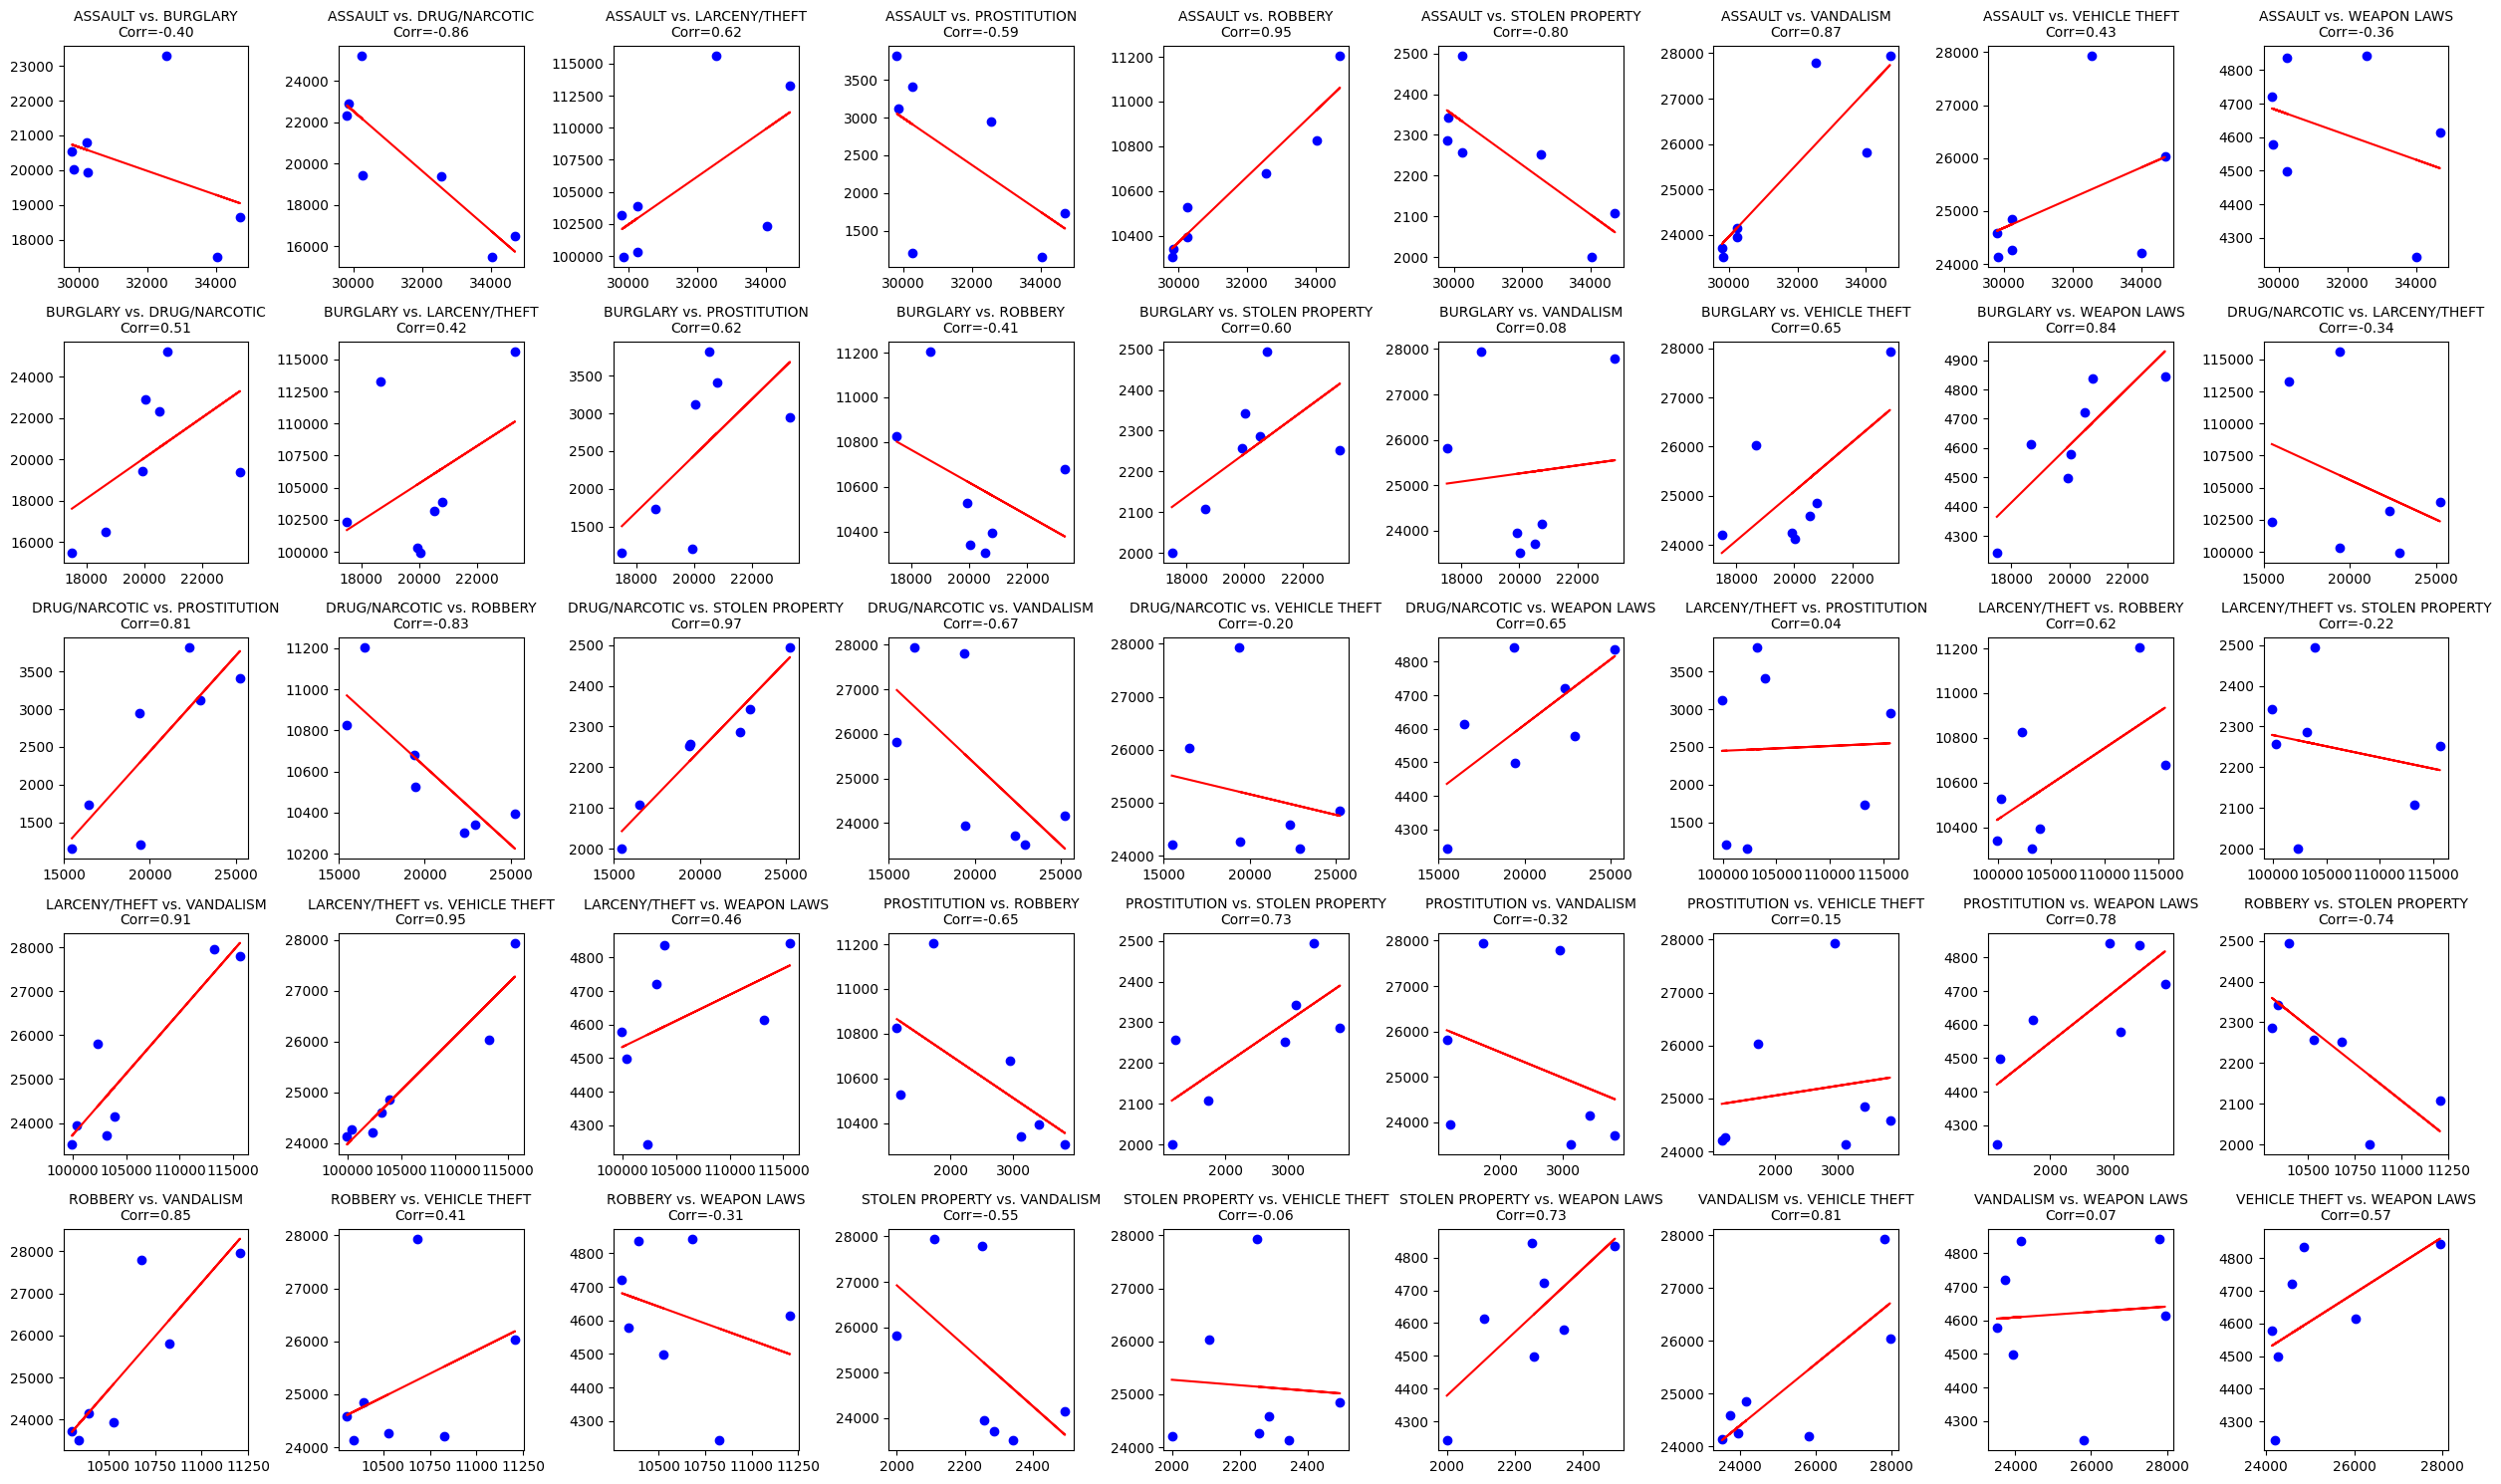

In [17]:
import itertools

# Prepare subplots for the 45 pairwise comparisons: C(10, 2) = 45
fig, axs = plt.subplots(nrows=5, ncols=9, figsize=(25, 15))
axarr = axs.flatten()  # Flatten so we can index easily

crime_categories = pivot_df.index.tolist()  # List of the 10 focus crimes

for i, (c1, c2) in enumerate(itertools.combinations(crime_categories, 2)):
    ax = axarr[i]
    
    # Extract the 7-day pattern (Mon-Sun) for each crime
    x = pivot_df.loc[c1].values  # e.g., [countMon, countTue, ..., countSun]
    y = pivot_df.loc[c2].values
    
    # Scatter plot
    ax.scatter(x, y, marker='o', color='blue')
    
    # Optional: Fit a simple linear regression line to see the trend
    if np.all(x == 0) and np.all(y == 0):
        # Edge case: if both are all zeros, skip the fit
        corr = 0
        slope, intercept = 0, 0
    else:
        slope, intercept = np.polyfit(x, y, 1)
        ax.plot(x, slope * x + intercept, color='red')
        # Compute correlation
        corr = np.corrcoef(x, y)[0, 1]
    
    # Label the subplot
    ax.set_title(f"{c1} vs. {c2}\nCorr={corr:.2f}", fontsize=10)

# Adjust layout to reduce overlapping labels
plt.tight_layout()
plt.show()


> Which pair of the 10 focus crimes have the the most similar temporal pattern across the week? (And which pair is most dissimilar).

The most similar temporal pattern have drug/narcotic and stolen property crimes with a correlation coefficient of 0.97. The most dissimilar are vandalism and weapon law crimes with a coefficient of 0.07. Drug narcotic and robbery are negatively correlated with a coefficient of -0.83. 

*Exercise:* Linear regression. 

> * Using Equation 1 and 2 above, calculate the slopes for $a$ and $b$ in each case and add them to the plot. 
> * You can add even more information to this plot by coloring each point according to its hour of the week. So create a gradient going from one color to another, and color each point according to the gradient. 
> * Do any patterns stand out as you inspect the plot? Mention one or two that catch your eye -- it may be both because the sequences are similar or because they are different, or something entirely different altogether.


In [18]:
from sklearn.linear_model import LinearRegression

def linear_regression_closed_form(x, y):
    """
    Compute slope (b) and intercept (a) using Janert's closed-form solution:
      b = [Σ(x_i y_i) - N*x̄*ȳ] / [Σ(x_i^2) - N*x̄^2]
      a = ȳ - b*x̄
    where x̄ and ȳ are means of x and y, and N is the number of points.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    N = len(x)
    x_mean = x.mean()
    y_mean = y.mean()
    
    # Numerator and denominator for slope
    num = (x * y).sum() - N * x_mean * y_mean
    den = (x**2).sum() - N * (x_mean**2)
    
    b = num / den
    a = y_mean - b * x_mean
    return b, a



In [19]:
# Choose two crime categories to compare
crime1 = 'ASSAULT'
crime2 = 'ROBBERY'

# Extract the day-of-week counts (e.g., Monday..Sunday)
x = pivot_df.loc[crime1].values  # shape (7,)
y = pivot_df.loc[crime2].values  # shape (7,)

# 1) Closed-form (Janert)
b_janert, a_janert = linear_regression_closed_form(x, y)

# 2) Scikit-learn
lr = LinearRegression(fit_intercept=True)
lr.fit(x.reshape(-1, 1), y)  # reshape for sklearn (7,1)
b_sklearn = lr.coef_[0]
a_sklearn = lr.intercept_

print(f"{crime1} vs. {crime2}:")
print(f"Janert Closed-Form => slope = {b_janert:.3f}, intercept = {a_janert:.3f}")
print(f"scikit-learn      => slope = {b_sklearn:.3f}, intercept = {a_sklearn:.3f}")

ASSAULT vs. ROBBERY:
Janert Closed-Form => slope = 0.147, intercept = 5970.431
scikit-learn      => slope = 0.147, intercept = 5970.431


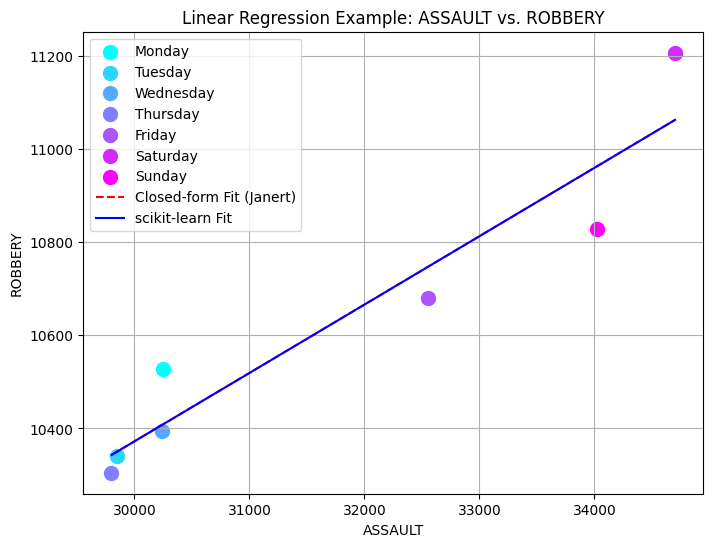

In [21]:
# Days of the week for labeling/coloring
days = pivot_df.columns.tolist()  # e.g. ["Monday", "Tuesday", ..., "Sunday"]

# Create a color gradient across the 7 days
colors = plt.cm.cool(np.linspace(0, 1, len(days)))

plt.figure(figsize=(8, 6))

# Plot each (x[i], y[i]) with a distinct color/label
for i, day in enumerate(days):
    plt.scatter(x[i], y[i], color=colors[i], s=100, label=day)

# Create a range of x-values for plotting the regression lines
x_line = np.linspace(x.min(), x.max(), 100)

# Janert line
y_line_janert = a_janert + b_janert * x_line
plt.plot(x_line, y_line_janert, 'r--', label='Closed-form Fit (Janert)')

# scikit-learn line
y_line_sklearn = a_sklearn + b_sklearn * x_line
plt.plot(x_line, y_line_sklearn, 'b-', label='scikit-learn Fit')

plt.title(f"Linear Regression Example: {crime1} vs. {crime2}")
plt.xlabel(crime1)
plt.ylabel(crime2)
plt.grid(True)
plt.legend()
plt.show()


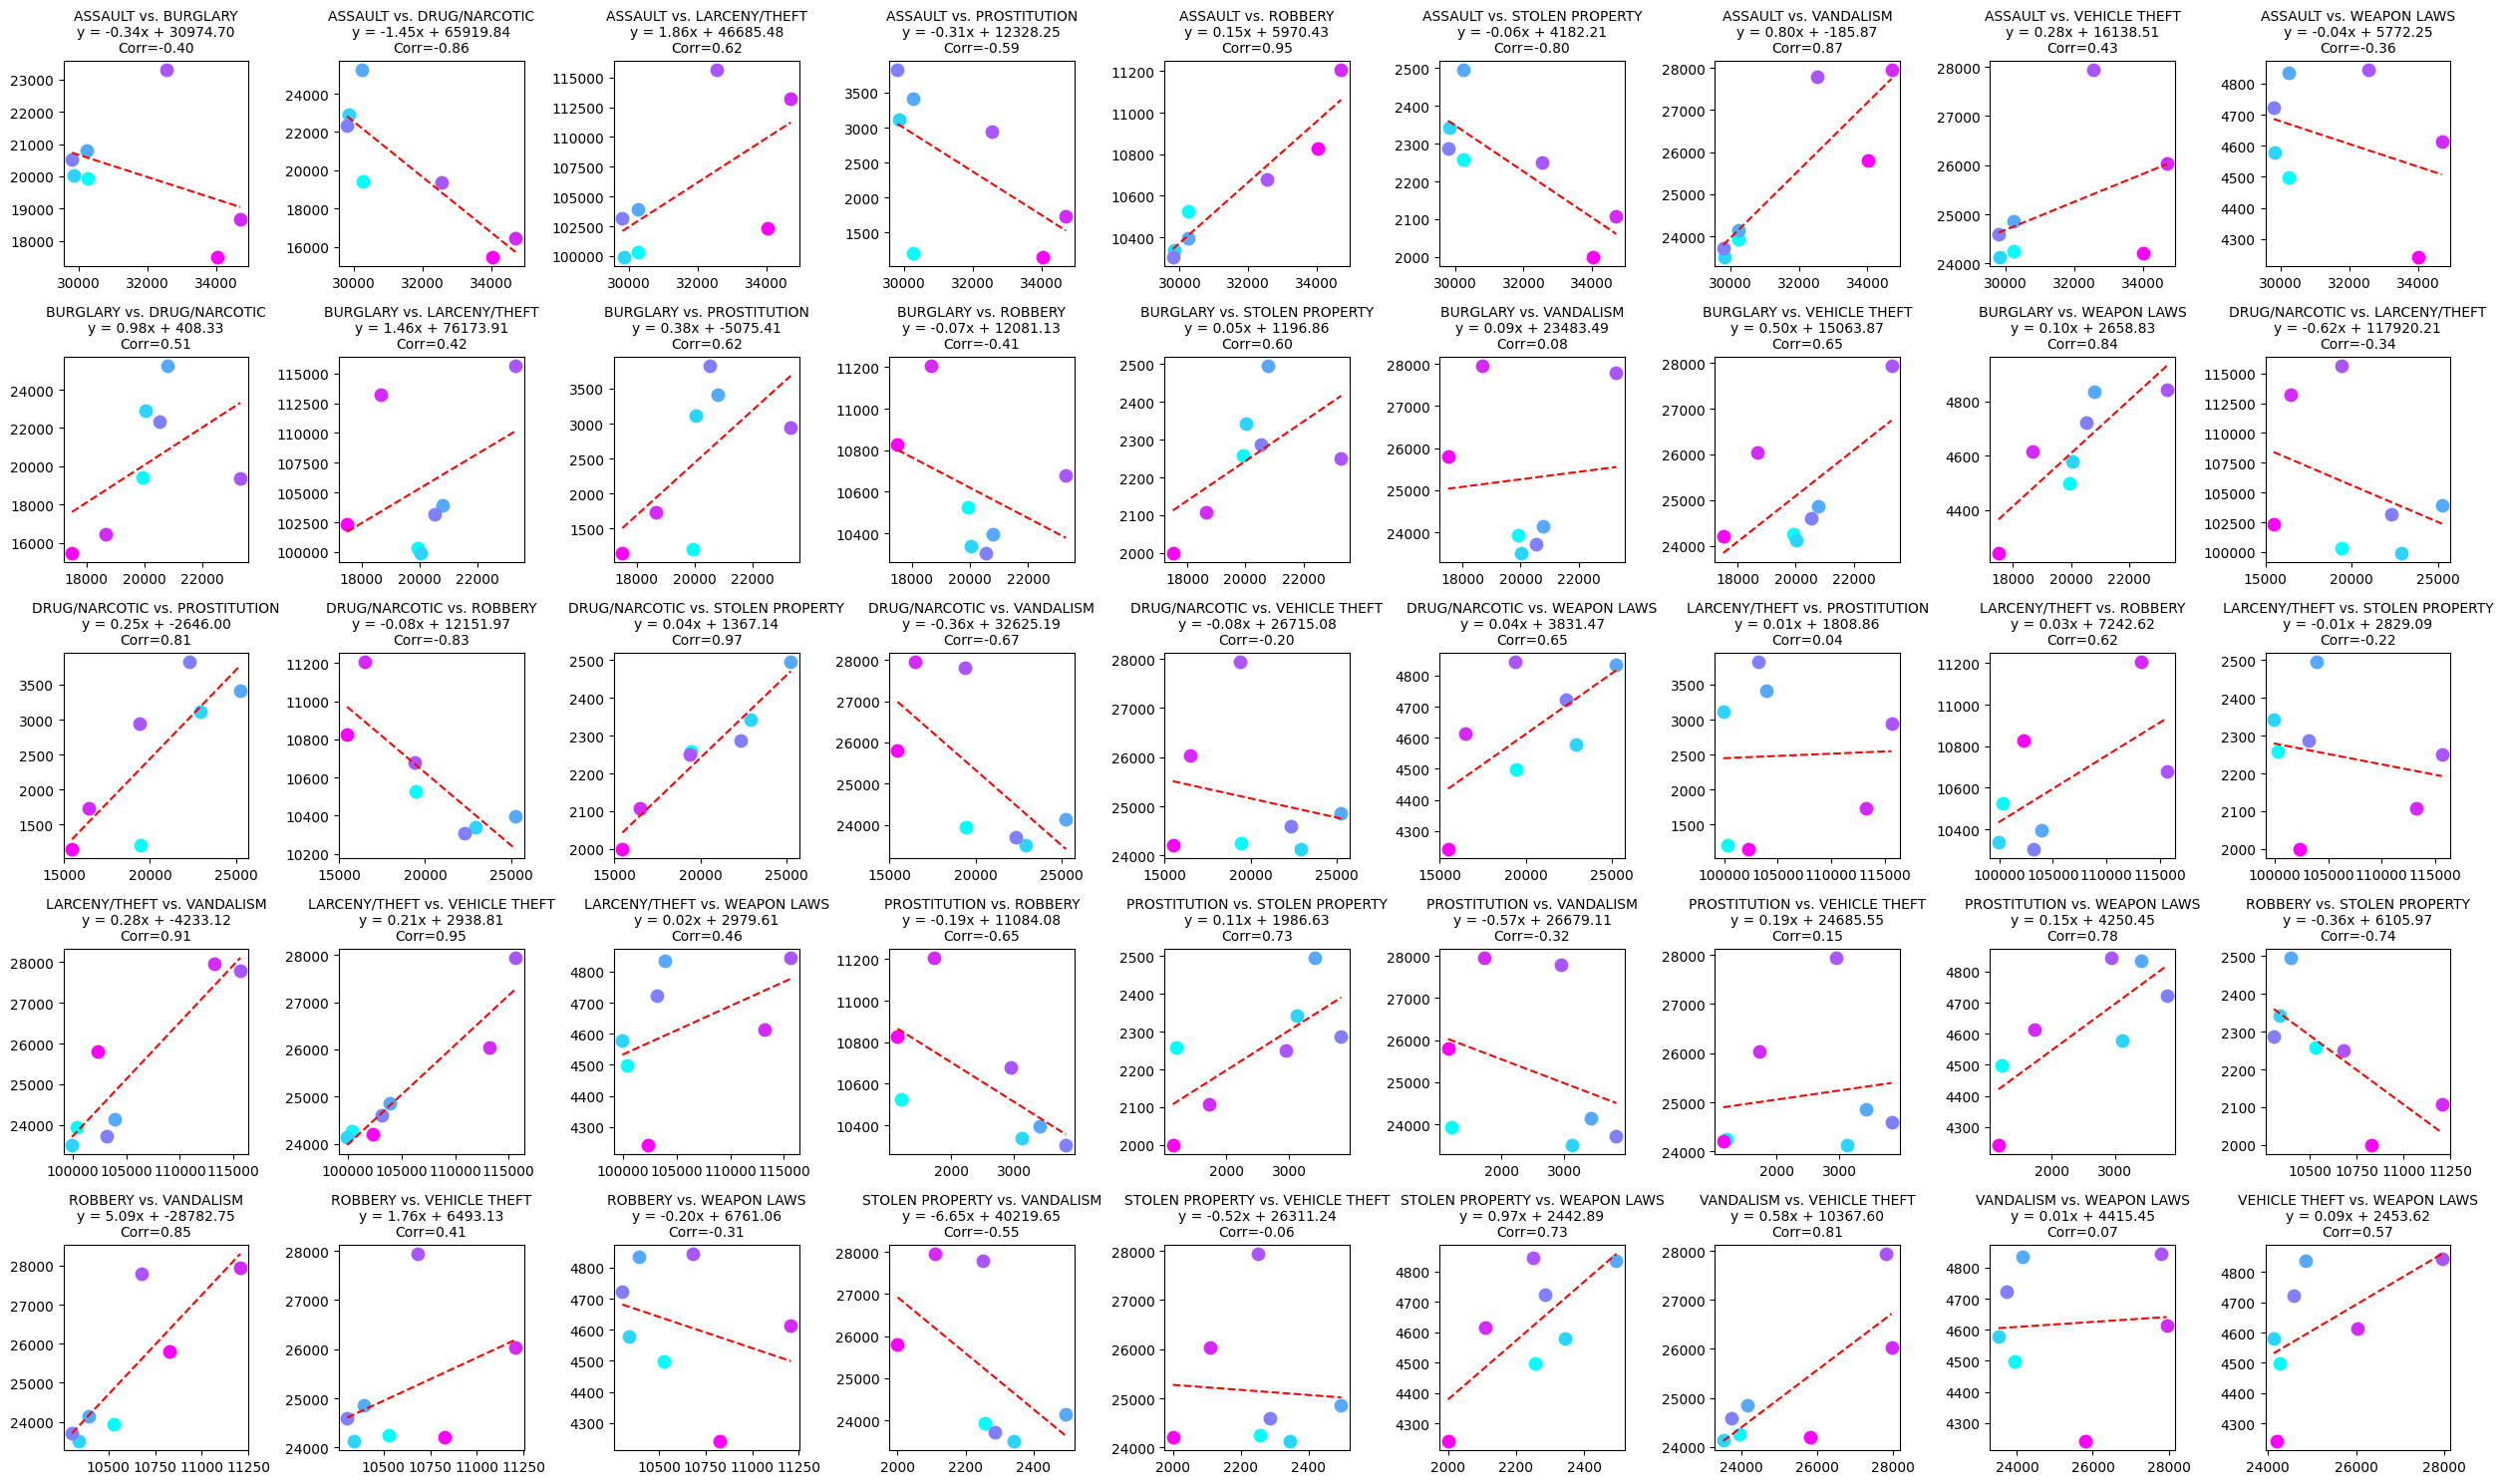

In [24]:
# And for all plots:

# Create a 5×9 grid of subplots (45 axes for the 45 pairs)
fig, axs = plt.subplots(nrows=5, ncols=9, figsize=(25, 15))
axarr = axs.flatten()

for i, (crime1, crime2) in enumerate(itertools.combinations(crime_categories, 2)):
    ax = axarr[i]
    
    # Extract the 7 day-of-week counts for each crime
    x = pivot_df.loc[crime1].values  # shape (7,)
    y = pivot_df.loc[crime2].values  # shape (7,)
    
    # Plot the 7 points, each with a different color for each day
    for day_idx in range(len(days)):
        ax.scatter(x[day_idx], y[day_idx], color=colors[day_idx], s=80)
    
    # Compute slope & intercept using Janert’s closed-form regression
    slope, intercept = linear_regression_closed_form(x, y)
    
    # Plot the regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = intercept + slope * x_line
    ax.plot(x_line, y_line, 'r--')
    corr = np.corrcoef(x, y)[0, 1]
    
    # Add a title showing the slope-intercept formula
    ax.set_title(
        f"{crime1} vs. {crime2}\n"
        f"y = {slope:.2f}x + {intercept:.2f}\n"
        f"Corr={corr:.2f}",
        fontsize=10
    )

# Hide any unused subplots (in case the grid has more slots than pairs)
for j in range(i+1, len(axarr)):
    axarr[j].set_visible(False)

plt.tight_layout()
plt.show()


/var/folders/4x/yhtdnw892qb8jnq411phhh340000gn/T/ipykernel_9417/3537603662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_focus['HourOfWeek'] = df_focus['Day of Week'].map(day_map) * 24 + df_focus['Hour']


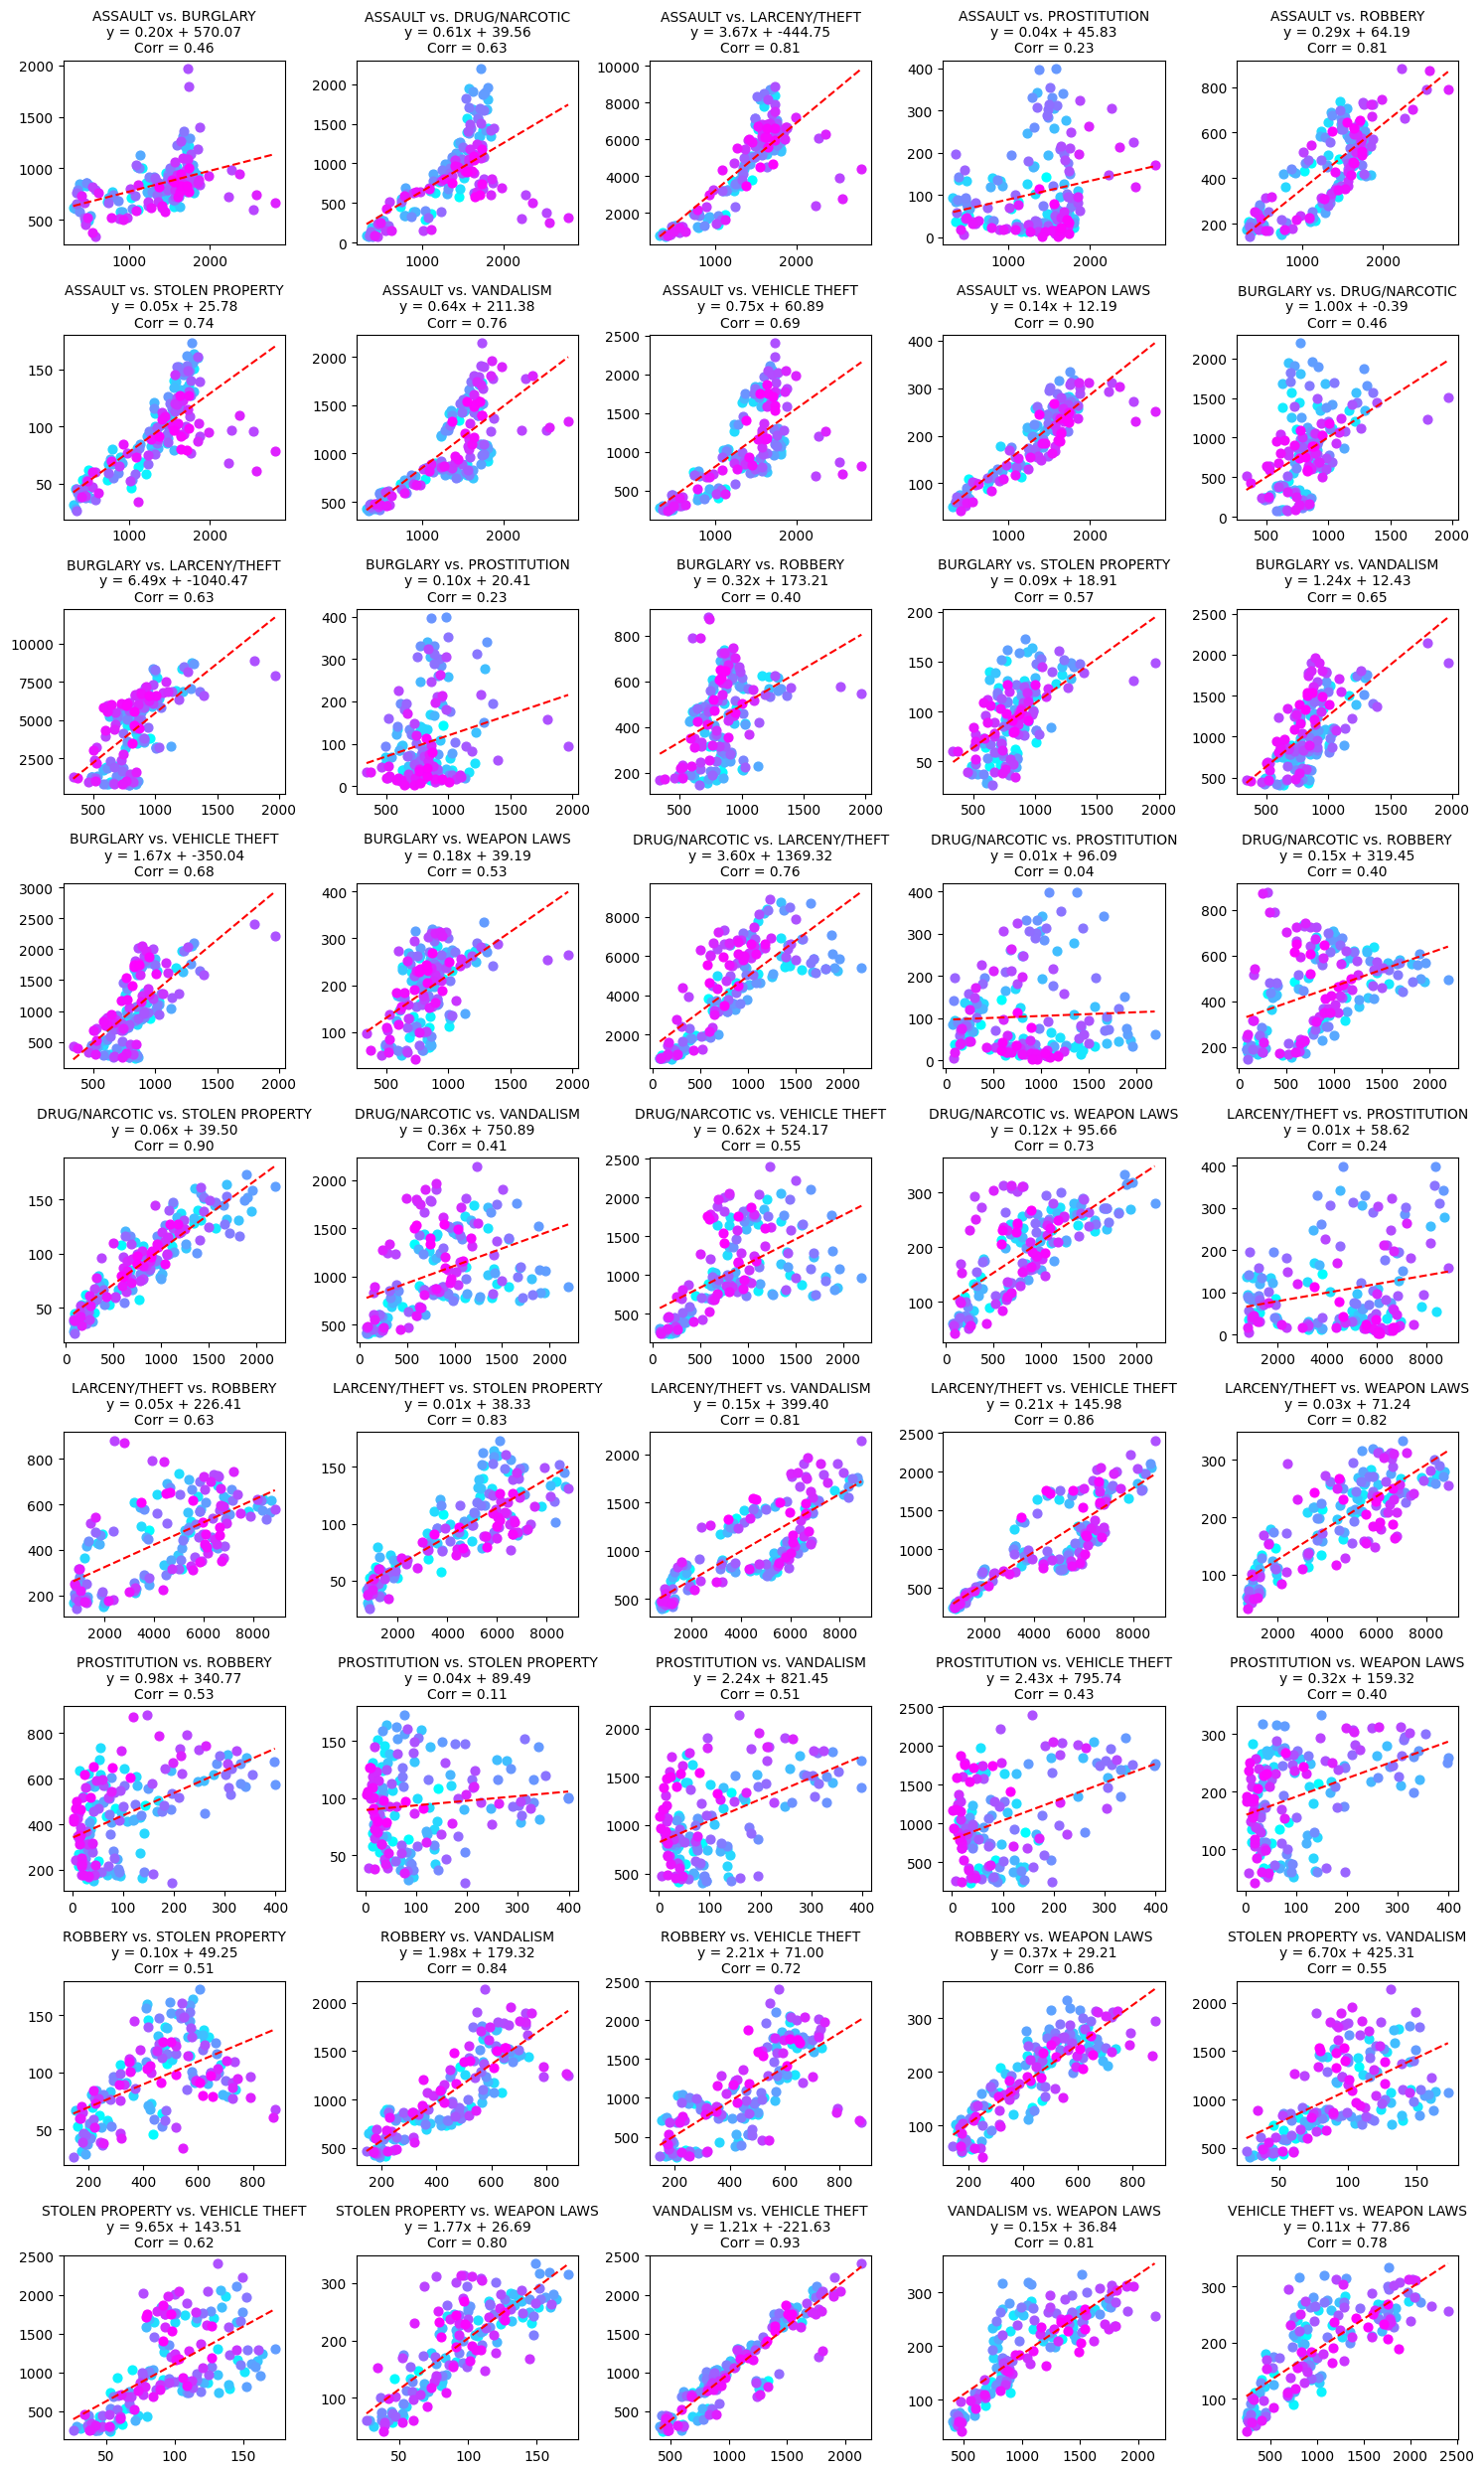

In [28]:
# Map day names to numbers (Monday=0, Tuesday=1, ..., Sunday=6)
day_map = {"Monday": 0, "Tuesday": 1, "Wednesday": 2, 
           "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6}

# Compute HourOfWeek: day_number * 24 + Hour (assumes 'Hour' is 0-23)
df_focus['HourOfWeek'] = df_focus['Day of Week'].map(day_map) * 24 + df_focus['Hour']

# --- Step 2: Create Pivot Table with Hour-of-Week Data ---
# Group by Category and HourOfWeek and count incidents
pivot_df_hour = (df_focus.groupby(['Category', 'HourOfWeek'])
                           .size()
                           .reset_index(name='count')
                           .pivot(index='Category', columns='HourOfWeek', values='count')
                           .fillna(0))

# Get the sorted list of HourOfWeek values (0 to 167)
hours = np.sort(pivot_df_hour.columns.values)

# Create a color gradient: one color for each hour (168 colors)
colors = plt.cm.cool(np.linspace(0, 1, len(hours)))

# --- Step 4: Create the 45 Pairwise Scatter Plots ---
fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(15, 25))
axarr = axs.flatten()

for i, (crime1, crime2) in enumerate(itertools.combinations(crime_categories, 2)):
    ax = axarr[i]
    
    # Extract the 168-hour counts for each crime
    x = pivot_df_hour.loc[crime1].values  # shape (168,)
    y = pivot_df_hour.loc[crime2].values  # shape (168,)
    
    # Plot each hour's data point with its unique color
    for hour_idx in range(len(hours)):
        ax.scatter(x[hour_idx], y[hour_idx], color=colors[hour_idx], s=40)
    
    # Compute the regression line using closed-form solution
    slope, intercept = linear_regression_closed_form(x, y)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = intercept + slope * x_line
    ax.plot(x_line, y_line, 'r--')
    
    # Compute correlation coefficient
    corr = np.corrcoef(x, y)[0, 1]
    
    # Set subplot title with regression formula and correlation
    ax.set_title(f"{crime1} vs. {crime2}\ny = {slope:.2f}x + {intercept:.2f}\nCorr = {corr:.2f}", fontsize=10)

# Hide any unused subplots (if the grid has more slots than needed)
for j in range(i+1, len(axarr)):
    axarr[j].set_visible(False)

plt.tight_layout()
plt.show()

*Exercise:* Goodness of fit as a measure of correlation. 
> * Write a little function to calculate $R^2$ alongside each linear fit. 
> * Explain the connection between $R^2$ and the Pearson correlation coefficient.

--> 

> * **According to the fits and associated $R^2$**, which pair of crimes have the **most similar** temporal pattern. Discuss your finding: Does it make sense? Why?/Why not?

--> 

> * According to your fits and associated measure of $R^2$, which pair of crimes have the **most dissimilar** temporal pattern. Discuss your finding: Does it make sense? Why?/Why not? Does it corresponds with your observations from the previous exercise?

--> 

> * Create a final mega-plot with all of the 91 megaplots, fits, and $R^2$ value written as text on each plot. In this figure, you should also find a way to visually highlight the two most similar/dissimilar crimes. 


In [36]:
def compute_r2(x, y):
    """
    1) Fit the line y_hat = a + b*x using the closed-form solution.
    2) Compute R^2 = 1 - [SS_res / SS_tot].
       - SS_res = Σ(y_i - y_hat_i)^2
       - SS_tot = Σ(y_i - ȳ)^2
    """
    slope, intercept = linear_regression_closed_form(x, y)
    y_pred = intercept + slope * x
    
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - y.mean())**2)
    r2 = 1 - (ss_res / ss_tot)
    return r2, slope, intercept

r2_results = []

# Generate all pairs of crimes (e.g., if you have 10 focus crimes, there are 45 pairs)
# Now we use the hour-based pivot table which has 168 data points per crime.
for c1, c2 in itertools.combinations(crime_categories, 2):
    # Get the 168 data points for each crime from the hour-based pivot table
    x = pivot_df_hour.loc[c1].values  # shape (168,)
    y = pivot_df_hour.loc[c2].values  # shape (168,)
    
    # Compute R^2, slope, and intercept for the hour-based data
    r2, slope, intercept = compute_r2(x, y)
    
    # Store the results
    r2_results.append((c1, c2, r2, slope, intercept))

# Sort pairs by R^2 in descending order (highest first)
r2_results.sort(key=lambda tup: tup[2], reverse=True)

# Print the top 5 (most similar) and bottom 5 (most dissimilar)
print("=== TOP 5 PAIRS BY R^2 (Most Similar) ===")
for i in range(5):
    c1, c2, r2, slope, intercept = r2_results[i]
    print(f"{c1} vs. {c2} | R^2 = {r2:.3f} | slope = {slope:.3f}, intercept = {intercept:.3f}")

print("\n=== BOTTOM 5 PAIRS BY R^2 (Most Dissimilar) ===")
for i in range(5):
    c1, c2, r2, slope, intercept = r2_results[-1 - i]
    print(f"{c1} vs. {c2} | R^2 = {r2:.3f} | slope = {slope:.3f}, intercept = {intercept:.3f}")



=== TOP 5 PAIRS BY R^2 (Most Similar) ===
VANDALISM vs. VEHICLE THEFT | R^2 = 0.869 | slope = 1.206, intercept = -221.632
ASSAULT vs. WEAPON LAWS | R^2 = 0.802 | slope = 0.137, intercept = 12.194
DRUG/NARCOTIC vs. STOLEN PROPERTY | R^2 = 0.801 | slope = 0.064, intercept = 39.504
LARCENY/THEFT vs. VEHICLE THEFT | R^2 = 0.741 | slope = 0.205, intercept = 145.980
ROBBERY vs. WEAPON LAWS | R^2 = 0.736 | slope = 0.369, intercept = 29.210

=== BOTTOM 5 PAIRS BY R^2 (Most Dissimilar) ===
DRUG/NARCOTIC vs. PROSTITUTION | R^2 = 0.002 | slope = 0.009, intercept = 96.094
PROSTITUTION vs. STOLEN PROPERTY | R^2 = 0.013 | slope = 0.041, intercept = 89.491
ASSAULT vs. PROSTITUTION | R^2 = 0.052 | slope = 0.044, intercept = 45.826
BURGLARY vs. PROSTITUTION | R^2 = 0.052 | slope = 0.099, intercept = 20.410
LARCENY/THEFT vs. PROSTITUTION | R^2 = 0.059 | slope = 0.010, intercept = 58.616


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

x_reshaped = x.reshape(-1, 1)  # needed for sklearn
lr = LinearRegression()
lr.fit(x_reshaped, y)
r2_sklearn = r2_score(y, lr.predict(x_reshaped))

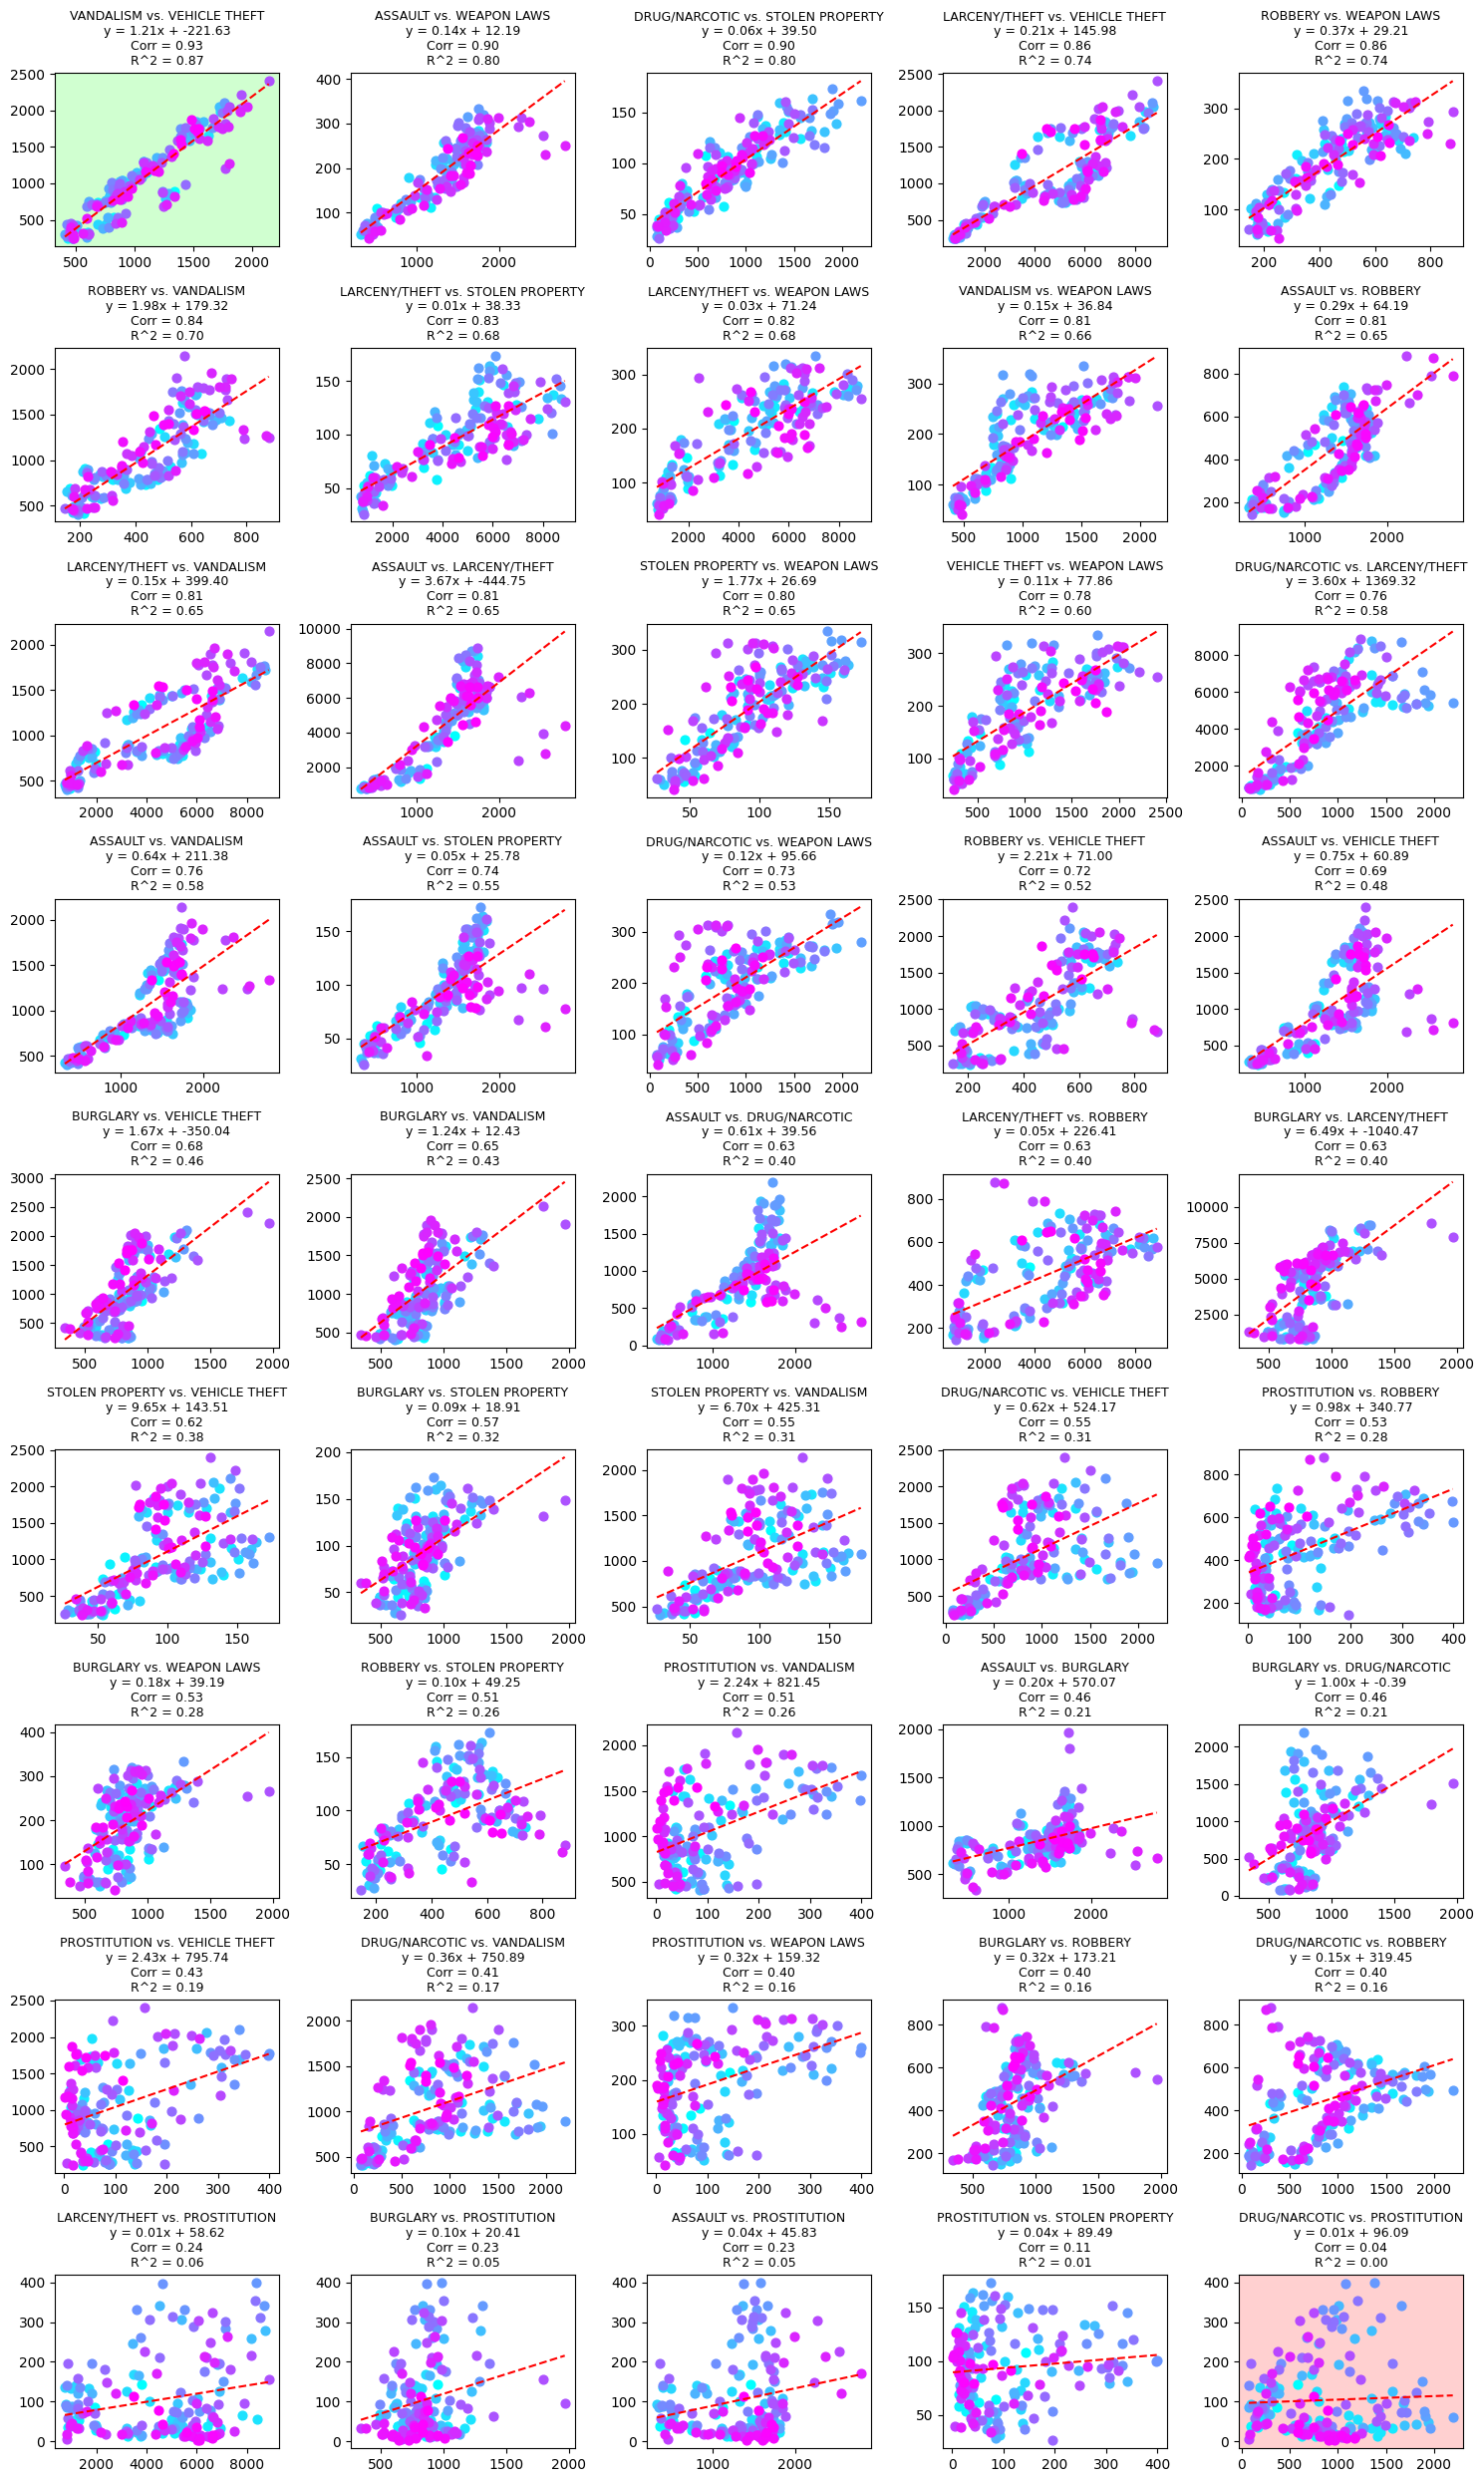

In [35]:

def compute_corr(x, y):
    """Return the Pearson correlation coefficient for arrays x, y."""
    return np.corrcoef(x, y)[0, 1]

###########################
# GATHER ALL PAIRS, SORT BY CORRELATION
###########################

pairs_data = []
for crime1, crime2 in itertools.combinations(crime_categories, 2):
    x = pivot_df_hour.loc[crime1].values  # shape (168,)
    y = pivot_df_hour.loc[crime2].values  # shape (168,)

    slope, intercept = linear_regression_closed_form(x, y)
    corr = compute_corr(x, y)
    r2 = compute_r2(x, y)[0]
    
    pairs_data.append((crime1, crime2, slope, intercept, corr, r2, x, y))

# Sort pairs by correlation (descending order: highest first)
pairs_data.sort(key=lambda row: row[4], reverse=True)

# Identify the top (most similar) and bottom (most dissimilar) pairs
highest_corr_pair = pairs_data[0]
lowest_corr_pair  = pairs_data[-1]

###########################
# CREATE THE MEGA-PLOT
###########################

fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(15, 25))
axarr = axs.flatten()

for i, (crime1, crime2, slope, intercept, corr, r2, x, y) in enumerate(pairs_data):
    ax = axarr[i]

    # Plot each hour's data point with its unique color
    for hour_idx in range(len(hours)):
        ax.scatter(x[hour_idx], y[hour_idx], color=colors[hour_idx], s=40)
    
    # Plot the regression line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = intercept + slope * x_line
    ax.plot(x_line, y_line, 'r--')
    
    # Title with slope–intercept formula & correlation
    ax.set_title(
        f"{crime1} vs. {crime2}\n"
        f"y = {slope:.2f}x + {intercept:.2f}\n"
        f"Corr = {corr:.2f}\n"
        f"R^2 = {r2:.2f}",
        fontsize=9
    )

    # HIGHLIGHT the subplots for the highest & lowest correlation
    # Option A: change facecolor
    if (crime1, crime2) == (highest_corr_pair[0], highest_corr_pair[1]):
        ax.set_facecolor("#d0ffd0")  # light green
    elif (crime1, crime2) == (lowest_corr_pair[0], lowest_corr_pair[1]):
        ax.set_facecolor("#ffd0d0")  # light red

# Hide any unused subplots (if your total pairs < total grid cells)
for j in range(i+1, len(axarr)):
    axarr[j].set_visible(False)

plt.tight_layout()
plt.show()
